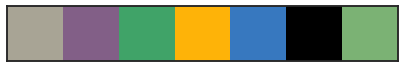

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf
from pprint import pprint
import re as re

from statsmodels.regression.mixed_linear_model import MixedLMResults
import networkx as nx

import scipy as sp
#from scipy.stats import nanmean
#from scipy.stats import nanstd
import copy
import scipy.stats as stats
import string

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from pprint import pprint
import seaborn as sns
sns.set(style="white", context="talk")
custom_palette = [ "greyish", "dusty purple", "greenish", "amber", "windows blue", "black","faded green"]  
                     #"green blue", "dull green", "faded green",  
sns.set_palette(sns.xkcd_palette(custom_palette))
current_palette = sns.color_palette()
%matplotlib inline
sns.palplot(current_palette)

import warnings
warnings.filterwarnings('ignore')


In [2]:
round_data = pd.read_csv('./all_studies_round_data.csv')
#round_data = round_data[round_data.round_index > 3]
#print(round_data.size)
conditions = ['dynamic_full_feedback',
              'dynamic',         
              'dynamic_self_feedback',
              'dynamic_no_feedback',
              'static',
              'solo_feedback',
              'solo_no_feedback'
             ]



colors ={'dynamic_no_feedback':'#196FFF',
         'dynamic_self_feedback':'#000000',
         'dynamic_full_feedback':'#E89468',
         'dynamic': '#81B200',
         'static':'#9B59B6',
         'solo_feedback': '#95A5A6',
         'solo_no_feedback': '#95A5A6'
        }


linestyles ={'dynamic_no_feedback':'-.',
         'dynamic_self_feedback':':',
         'dynamic_full_feedback':'-',
         'dynamic': '-',
         'static':'--',
         'solo_feedback': '-',
         'solo_no_feedback': '-'
        }


markers ={'dynamic_no_feedback':'d',
         'dynamic_self_feedback':'^',
         'dynamic_full_feedback':'p',
         'dynamic': 'o',
         'static':'*',
         'solo_feedback': 'H',
         'solo_no_feedback': 'h'
        }


#markers = ['s','o','*']
#linestyles = ['--','-',':','-.']
tick_size = 25
label_size = 35


network_conditions = ['dynamic_full_feedback','dynamic','dynamic_no_feedback','dynamic_self_feedback','static']

studies = [1,2]


In [3]:
round_data.columns

Index(['game_id', 'condition', 'round_index', 'correct_answer',
       'plot_sequence', 'player_id', 'cumulative_score', 'difficulty',
       'revised_guess', 'revised_error', 'alter_1', 'alter_2', 'alter_3',
       'increment', 'increment_color', 'in_degree', 'study',
       'alter_1_revised_guess', 'alter_2_revised_guess',
       'alter_3_revised_guess', 'alter_1_independent_guess',
       'alter_2_independent_guess', 'alter_3_independent_guess',
       'round_after_shock', 'quarter', 'task_instance_avg_error',
       'revised_error_relative2solo', 'independent_error_relative2solo',
       'independent_guess', 'independent_error', 'half', 'best_player',
       'ind_score', 'cumulative_ind_score', 'final_score', 'final_ind_score',
       'improvement', 'group', 'best_player_initial', 'best_player_revised'],
      dtype='object')

# Helper functions

In [4]:
def create_network(game_id, condition):
    networks={}
    for round_index in range(1,20+1):
        networks[round_index] = nx.DiGraph(correct_answer=round_data[round_data.round_index==round_index].correct_answer.iloc[0],
                                          condition=condition,game_id = game_id)
    for i,row in round_data[(round_data.game_id==game_id) & (round_data.condition == condition)].iterrows():
        networks[row.round_index].add_node(row.player_id,name=row.player_id) 
        networks[row.round_index].nodes[row.player_id]['cumulative_score']= row.cumulative_score
        networks[row.round_index].nodes[row.player_id]['independent_guess']= row.independent_guess
        networks[row.round_index].nodes[row.player_id]['independent_error']= row.independent_error
        networks[row.round_index].nodes[row.player_id]['revised_guess']= row.revised_guess
        networks[row.round_index].nodes[row.player_id]['increment']= row.increment
        networks[row.round_index].nodes[row.player_id]['revised_error']= row.revised_error
        networks[row.round_index].nodes[row.player_id]['shape']= 'o'
        #networks[row.round_index].node[row.player_id]['color']= row.cumulative_color
        
        lst = list(round_data[(round_data.game_id==game_id) & (round_data.condition==condition) &
                              (round_data.round_index==row.round_index)]['cumulative_score'])        

        norm = matplotlib.colors.Normalize(vmin=min(lst), vmax=max(lst))
        #norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn)
        networks[row.round_index].nodes[row.player_id]['gradient_color']=mapper.to_rgba(row.cumulative_score)

        networks[row.round_index].nodes[row.player_id]['size']= 140 + (row.in_degree**1.4)*500 if row.in_degree > 0 else 200
        for i in range(1,3+1):
            if isinstance(row['alter_'+str(i)],str): #in case someone follows less than 3
                networks[row.round_index].add_edge(row.player_id, row['alter_'+str(i)])
    return networks



def freeman_centralization(G):
    N=G.order()
    indegrees = list(dict(G.in_degree()).values())
    #print('indegrees',indegrees)
    max_in = max(indegrees)
    return float((N*max_in - sum(indegrees)))/(N-1)**2



    
def centrality_performance_correlation(G):
    performance = []
    centralities = []
    try:
        centrality = nx.eigenvector_centrality(G)
    except:
        return np.nan
    #print(centrality)

    for node in list(dict(G.nodes.data()).values()):
        #print(G.in_degree(node['name']))
        centralities.append(centrality[node['name']])
        performance.append(node['cumulative_score']) ##this is the origianl measure
        #performance.append(node['independent_error']) ##this is trying things out
        
    #print(indegrees)
    correlation = pd.DataFrame({'centralities': centralities,
                   'performance': performance}).corr().centralities.performance

    return 0 if np.isnan(correlation) else correlation

def degree_performance_correlation(G):
    performance = []
    indegrees = []
    for node in list(dict(G.nodes.data()).values()):
        #print(G.in_degree(node['name']))
        indegrees.append(G.in_degree(node['name']))
        performance.append(node['cumulative_score']) ##this is the origianl measure
        #performance.append(node['independent_error']) ##this is trying things out
        
    #print(indegrees)
    correlation = pd.DataFrame({'indegrees': indegrees,
                   'performance': performance}).corr().indegrees.performance

    return 0 if np.isnan(correlation) else correlation

# Generating network data

In [22]:
network_cent = {'round_index':[],
                'freeman_centralization':[],
                'condition':[], 'game_id':[], 'change_frequency':[]}
networks = {}

for condition in conditions:
    networks[condition] = []

for condition in network_conditions:
    game_ids = round_data[round_data.condition==condition].game_id.unique()
    for game_id in game_ids:
        G = create_network(game_id, condition)
        networks[condition].append(G)
        for rid in G.keys():
            network_cent['freeman_centralization'].append(freeman_centralization(G[rid]))
            network_cent['round_index'].append(rid+1)
            network_cent['condition'].append(condition)
            network_cent['game_id'].append(game_id)
            try:
                network_cent['change_frequency'].append(len(nx.difference(G[rid],G[rid-1]).edges())) ##how many edges changed
            except:
                network_cent['change_frequency'].append(None)
                



In [30]:
centerlization_data = pd.DataFrame.from_dict(network_cent)
centerlization_data['quarter'] = None
centerlization_data.loc[centerlization_data['round_index'] < 6, 'quarter'] = 1
centerlization_data.loc[(centerlization_data['round_index'] >= 6) &
                                          (centerlization_data['round_index'] < 11), 'quarter'] = 2
centerlization_data.loc[(centerlization_data['round_index'] >= 11) & 
                                          (centerlization_data['round_index'] < 16), 'quarter'] = 3
centerlization_data.loc[centerlization_data['round_index'] >= 16, 'quarter'] = 4


centerlization_data['half'] = None
centerlization_data.loc[centerlization_data.round_index < 11, 'half'] = 1
centerlization_data.loc[centerlization_data.round_index > 10, 'half'] = 2
#centerlization_data

centerlization_data['adapted'] = False
centerlization_data.loc[centerlization_data['quarter'].isin([2,4]), 'adapted'] = True
centerlization_data['freeman_centralization'] = centerlization_data['freeman_centralization'].astype(np.float64)
centerlization_data['quarter'] = centerlization_data['quarter'].astype(np.float64)

## Popularity and Performance

dynamic_full_feedback p #E89468 -
dynamic o #81B200 -
dynamic_no_feedback d #196FFF -.
dynamic_self_feedback ^ #000000 :
static * #9B59B6 --
dynamic_full_feedback p #E89468 -
dynamic o #81B200 -
dynamic_no_feedback d #196FFF -.
dynamic_self_feedback ^ #000000 :
static * #9B59B6 --


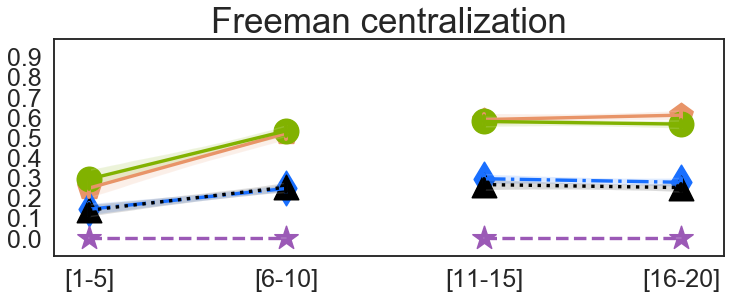

In [32]:
x_formatter = ticker.FixedFormatter([
    "[1-5]", "[6-10]", "[11-15]", "[16-20]"])
x_locator = ticker.FixedLocator([1, 2, 3, 4])



fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
for half in range(1,2+1):
    for condition in network_conditions:
        print(condition,markers[condition], colors[condition],linestyles[condition])
        sns.regplot(x="quarter",
                    y="freeman_centralization",
                    data=centerlization_data[(centerlization_data.half==half)
                                             & (centerlization_data.condition==condition)],
                    x_estimator=np.mean,
                    ax=ax,
                    truncate=True,
                    marker=markers[condition],
                    color=colors[condition],
                    line_kws = {'linestyle':linestyles[condition]},
                    scatter_kws ={'s':600},

                    fit_reg=True,
                    ci=95,
                    label=condition,
                   )

ax.set_xlabel("",fontsize=label_size)
ax.set_title('Freeman centralization',fontsize=label_size)
ax.set_ylabel("")
#ax.set_xlim(0.5,4.5)
ax.set_ylim(-0.09,0.99)

ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)


ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax.tick_params(labelsize=tick_size)


In [33]:
data=centerlization_data[(centerlization_data.condition.isin(['dynamic','full_feedback'])) & 
                         (centerlization_data.quarter.isin([2,3]))
                        ]
forumla = "freeman_centralization ~ adapted"
model = smf.mixedlm(forumla,
                    data=data,
                    groups=data['game_id']).fit(method='powell')
print(model.summary())



# for quarter in range(1,4+1):
#     print("quarter", quarter)
#     data = centerlization_data[(centerlization_data.condition != 'static') 
#                                               & (centerlization_data.quarter==quarter)]
#     forumla = "freeman_centralization ~ round_index"
#     model = smf.mixedlm(forumla,
#                         data=data,
#                         groups=data['game_id']).fit(method='powell')
#     print(model.summary())
model.summary()

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: freeman_centralization
No. Observations: 200     Method:             REML                  
No. Groups:       20      Scale:              0.0066                
Min. group size:  10      Log-Likelihood:     184.7287              
Max. group size:  10      Converged:          Yes                   
Mean group size:  10.0                                              
----------------------------------------------------------------------
                  Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept          0.580      0.025   23.652   0.000    0.532    0.628
adapted[T.True]   -0.046      0.011   -4.042   0.000   -0.069   -0.024
Group Var          0.011      0.048                                   



<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:            MixedLM Dependent Variable: freeman_centralization
No. Observations: 200     Method:             REML                  
No. Groups:       20      Scale:              0.0066                
Min. group size:  10      Log-Likelihood:     184.7287              
Max. group size:  10      Converged:          Yes                   
Mean group size:  10.0                                              
----------------------------------------------------------------------
                  Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept          0.580      0.025   23.652   0.000    0.532    0.628
adapted[T.True]   -0.046      0.011   -4.042   0.000   -0.069   -0.024
Group Var          0.011      0.048                                   
====================================================================

"""

# Score / Popularity Correlation

In [36]:
network_score_degree_corr = {'round_index':[],'score_degree_corr':[], 'condition':[], 'game_id':[]}

for condition in conditions:
    for G in networks[condition]:
        for rid in G.keys():
            network_score_degree_corr['score_degree_corr'].append(degree_performance_correlation(G[rid]))
            network_score_degree_corr['round_index'].append(rid)
            network_score_degree_corr['condition'].append(condition)
            network_score_degree_corr['game_id'].append(G[rid].graph['game_id'])
            
popularity_data = pd.DataFrame.from_dict(network_score_degree_corr)
popularity_data['round_after_shock'] = popularity_data.round_index
popularity_data['round_after_shock'] = np.where(popularity_data['round_index'] > 10 ,
                                                popularity_data['round_index']-10,
                                                popularity_data['round_after_shock']) 


popularity_data['quarter'] = None
popularity_data.loc[popularity_data['round_index'] < 6, 'quarter'] = 1
popularity_data.loc[(popularity_data['round_index'] >= 6) &
                                          (popularity_data['round_index'] < 11), 'quarter'] = 2
popularity_data.loc[(popularity_data['round_index'] >= 11) & 
                                          (popularity_data['round_index'] < 16), 'quarter'] = 3
popularity_data.loc[popularity_data['round_index'] >= 16, 'quarter'] = 4


popularity_data['half'] = None
popularity_data.loc[popularity_data.round_index < 11, 'half'] = 1
popularity_data.loc[popularity_data.round_index > 10, 'half'] = 2
popularity_data['quarter'] = popularity_data['quarter'].astype(np.float64)

dynamic_full_feedback p #E89468 -
dynamic o #81B200 -
dynamic_no_feedback d #196FFF -.
dynamic_self_feedback ^ #000000 :
static * #9B59B6 --
dynamic_full_feedback p #E89468 -
dynamic o #81B200 -
dynamic_no_feedback d #196FFF -.
dynamic_self_feedback ^ #000000 :
static * #9B59B6 --


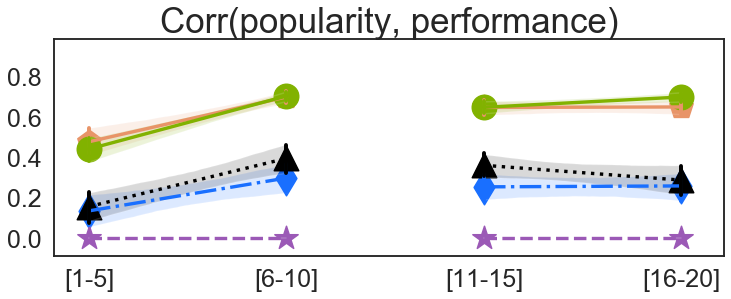

In [37]:
x_formatter = ticker.FixedFormatter([
    "[1-5]", "[6-10]", "[11-15]", "[16-20]"])
x_locator = ticker.FixedLocator([1, 2, 3, 4])



fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
for half in range(1,2+1):
    for condition in network_conditions:
        print(condition,markers[condition], colors[condition],linestyles[condition])
        sns.regplot(x="quarter",
                    y="score_degree_corr",
                    data=popularity_data[(popularity_data.half==half) & (popularity_data.condition==condition)],
                    x_estimator=np.mean,
                    ax=ax,
                    truncate=True,
                    marker=markers[condition],
                    color=colors[condition],
                    line_kws = {'linestyle':linestyles[condition]},
                    scatter_kws ={'s':600},

                    fit_reg=True,
                    ci=95,
                    label=condition,
                   )

ax.set_xlabel("",fontsize=label_size)
ax.set_title('Corr(popularity, performance)',fontsize=label_size)
ax.set_ylabel("")
#ax.set_xlim(0.5,4.5)
ax.set_ylim(-0.09,0.99)

ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)


ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.tick_params(labelsize=tick_size)



# Local Adaptation:  Confidenec and Accuracy

In [40]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def arrayRange(x, axis=0):
    return np.max(x, axis=axis) - np.min(x, axis=axis)

def confidence_accuracy_correlation(G):
    error_count = 0
    confidence = []
    accuracy = []
    weights = []
    for node_name, node_data in G.nodes.data():
        neighbors_guesses=[]
        for neighbor in G.successors(node_name):
            neighbors_guesses.append(G.nodes[neighbor]['independent_guess'])
        
        accuracy.append(1-np.abs(node_data["independent_error"]))
        
        initial = node_data["independent_guess"]
        advice = np.array(neighbors_guesses).mean()
        revised = node_data["revised_guess"]
        weight_on_self = (revised-advice) / (initial - advice)
        
        
        weight = np.array(initial - advice)
        #print(weight)
        weights.append(np.abs(weight))
        
        confidence.append(weight_on_self)

#         weights.append(np.nan)
#         confidence.append(np.nan)
    temp_df = pd.DataFrame({'confidence': confidence,
                   'accuracy': accuracy, 'weights':weights})
    
    correlation = corr(temp_df['confidence'],temp_df['accuracy'],temp_df['weights'])
    #correlation = corr(temp_df['confidence'],temp_df['accuracy'])
    #correlation = pd.DataFrame({'confidence': confidence,
    #           'accuracy': accuracy}).corr().confidence.accuracy

    #print(correlation)
           
    #print(error_count)
    return 0 if np.isnan(correlation) else correlation

In [45]:
confidence = {'round_index':[],'conf_accuracy_corr':[], 'condition':[], 'game_id':[]}

for condition in network_conditions:

    for G in networks[condition]:
        for rid in G.keys():
            con_correlation = confidence_accuracy_correlation(G[rid])
            confidence['conf_accuracy_corr'].append(con_correlation)
            #confidence['soc_correlation'].append(soc_correlation)
            confidence['round_index'].append(rid)
            confidence['condition'].append(condition)
            confidence['game_id'].append(G[rid].graph['game_id'])
            
            

confidence_data = pd.DataFrame.from_dict(confidence)
confidence_data['round_after_shock'] = confidence_data.round_index
confidence_data['round_after_shock'] = np.where(confidence_data['round_index'] > 10 ,
                                                confidence_data['round_index']-10,
                                                confidence_data['round_after_shock']) 
confidence_data['quarter'] = None
confidence_data.loc[confidence_data['round_index'] < 6, 'quarter'] = 1
confidence_data.loc[(confidence_data['round_index'] >= 6) &
                                          (confidence_data['round_index'] < 11), 'quarter'] = 2
confidence_data.loc[(confidence_data['round_index'] >= 11) & 
                                          (confidence_data['round_index'] < 16), 'quarter'] = 3
confidence_data.loc[confidence_data['round_index'] >= 16, 'quarter'] = 4


confidence_data['half'] = None
confidence_data.loc[confidence_data.round_index < 11, 'half'] = 1
confidence_data.loc[confidence_data.round_index > 10, 'half'] = 2
confidence_data['quarter'] = popularity_data['quarter'].astype(np.float64)

dynamic_full_feedback p #E89468 -
dynamic o #81B200 -
dynamic_no_feedback d #196FFF -.
dynamic_self_feedback ^ #000000 :
static * #9B59B6 --
dynamic_full_feedback p #E89468 -
dynamic o #81B200 -
dynamic_no_feedback d #196FFF -.
dynamic_self_feedback ^ #000000 :
static * #9B59B6 --


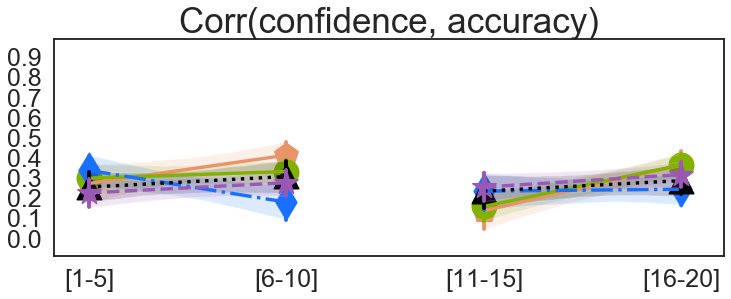

In [46]:
x_formatter = ticker.FixedFormatter([
    "[1-5]", "[6-10]", "[11-15]", "[16-20]"])
x_locator = ticker.FixedLocator([1, 2, 3, 4])




fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
for half in range(1,2+1):
    for condition in network_conditions:
        print(condition,markers[condition], colors[condition],linestyles[condition])
        sns.regplot(x="quarter",
                    y="conf_accuracy_corr",
                    data=confidence_data[(confidence_data.half==half) & (confidence_data.condition==condition)],
                    x_estimator=np.mean,
                    ax=ax,
                    truncate=True,
                    marker=markers[condition],
                    color=colors[condition],
                    line_kws = {'linestyle':linestyles[condition]},
                    scatter_kws ={'s':600},
                    fit_reg=True,
                    ci=95,
                    label=condition,
                   )

ax.set_xlabel("",fontsize=label_size)
ax.set_title('Corr(confidence, accuracy)',fontsize=label_size)
ax.set_ylabel("")
#ax.set_xlim(0.5,4.5)
ax.set_ylim(-0.09,0.99)

ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)


ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax.tick_params(labelsize=tick_size)


#plt.savefig('./conf_accuracy.pdf')

In [47]:
confidence_data

,round_index,conf_accuracy_corr,condition,game_id,round_after_shock,quarter,half
0,1,4.453320e-01,dynamic_full_feedback,24BpJ5vFZLjtAx3YY,1,1.0,1
1,2,2.756550e-01,dynamic_full_feedback,24BpJ5vFZLjtAx3YY,2,1.0,1
2,3,6.526850e-02,dynamic_full_feedback,24BpJ5vFZLjtAx3YY,3,1.0,1
3,4,4.478084e-08,dynamic_full_feedback,24BpJ5vFZLjtAx3YY,4,1.0,1
4,5,-1.213292e-01,dynamic_full_feedback,24BpJ5vFZLjtAx3YY,5,1.0,1
...,...,...,...,...,...,...,...
1695,16,-1.340494e-01,static,63,6,4.0,2
1696,17,-2.949893e-01,static,63,7,4.0,2
1697,18,8.199131e-01,static,63,8,4.0,2
1698,19,1.440123e-01,static,63,9,4.0,2


# increased individual capability explanation

Does group interaction enable the group members to come up with better individual estimates, and averaging these better estimates leads to improved group performance compared to the averaged initial individual estimates.

dynamic o
static *
solo_feedback H
dynamic o
static *
solo_feedback H
dynamic_no_feedback d
dynamic_full_feedback p
dynamic_self_feedback ^
solo_no_feedback h
dynamic_no_feedback d
dynamic_full_feedback p
dynamic_self_feedback ^
solo_no_feedback h


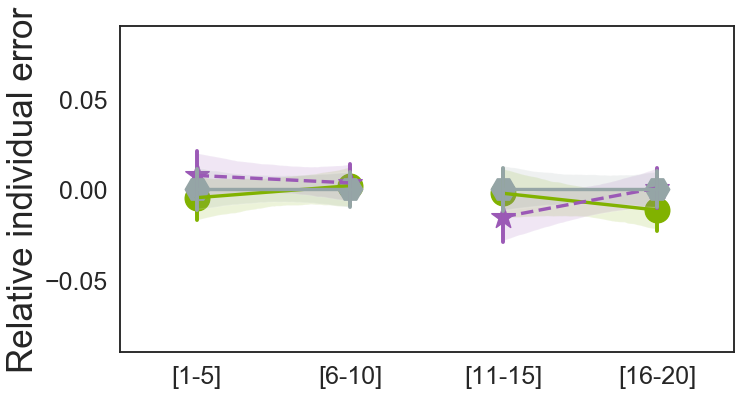

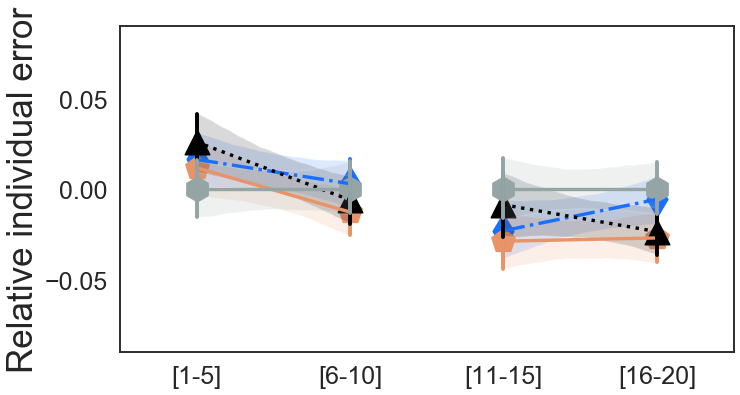

In [48]:
x_formatter = ticker.FixedFormatter([
    "[1-5]", "[6-10]", "[11-15]", "[16-20]"])
x_locator = ticker.FixedLocator([1, 2, 3, 4])


for study_number in studies:
    fig = plt.figure(figsize=(11,6))
    ax = fig.add_subplot(111)
    for half in range(1,2+1):
        for condition in round_data[round_data.study==study_number].condition.unique():
            print(condition,markers[condition])
            sns.regplot(x="quarter",
                        y="independent_error_relative2solo",
                        data=round_data[(round_data.half==half) & (round_data.condition==condition)],
                        x_estimator=np.mean, ax=ax,
                        truncate=True,
                        marker=markers[condition],
                        color=colors[condition],
                        line_kws = {'linestyle':linestyles[condition]},
                        scatter_kws ={'s':600},
                    
                        fit_reg=True,
                        ci=95,
                        label=condition,
                       )
            
    ax.set_xlabel("",fontsize=label_size)
    ax.set_ylabel('Relative individual error',fontsize=label_size)

    ax.set_xlim(0.5,4.5)
    ax.set_ylim(-0.09,0.09)

    ax.xaxis.set_major_formatter(x_formatter)
    ax.xaxis.set_major_locator(x_locator)

    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    
    ax.tick_params(labelsize=tick_size)
    #plt.savefig("G_i_individual_s"+str(study_number)+'.pdf', dpi=200, bbox_inches='tight', format = 'pdf')

In [49]:
for condition in popularity_data.condition.unique():
    print(condition ,popularity_data[popularity_data.condition==condition].score_degree_corr.mean())

dynamic_full_feedback 0.6204308077596044
dynamic 0.6250948161938205
dynamic_self_feedback 0.30106065705168567
dynamic_no_feedback 0.23725667263266914
static 0.0


In [50]:
forumla = "score_degree_corr ~ C(condition, Treatment('dynamic_full_feedback'))"


model = smf.mixedlm(forumla,data=popularity_data[popularity_data.condition != 'dynamic'],groups='game_id').fit(method='powell')


print(" β: ",model.params[1], ', t-statistic',model.tvalues[1], ', pvalue ', model.pvalues[1], 
      ' ci ', model.conf_int()[0][1], model.conf_int()[1][1])#print (' ---- ')
model.summary()

 β:  -0.3831741351269335 , t-statistic -6.515677924349985 , pvalue  7.236209212161641e-11  ci  -0.4984357415745842 -0.2679125286792828


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                        Mixed Linear Model Regression Results
=====================================================================================================================
Model:                              MixedLM                   Dependent Variable:                   score_degree_corr
No. Observations:                   1300                      Method:                               REML             
No. Groups:                         65                        Scale:                                0.0347           
Min. group size:                    20                        Log-Likelihood:                       244.7305         
Max. group size:                    20                        Converged:                            Yes              
Mean group size:                    20.0                                                                             
---------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                                                  0.620    0.042  14.920 0.000  0.539  0.702
C(condition, Treatment('dynamic_full_feedback'))[T.dynamic_no_feedback]   -0.383    0.059  -6.516 0.000 -0.498 -0.268
C(condition, Treatment('dynamic_full_feedback'))[T.dynamic_self_feedback] -0.319    0.059  -5.431 0.000 -0.435 -0.204
C(condition, Treatment('dynamic_full_feedback'))[T.static]                -0.620    0.055 -11.279 0.000 -0.728 -0.513
game_id Var                                                                0.024    0.026                            
=====================================================================================================================

"""